# Загрузка библиотек

In [3]:
import pandas as pd
import requests
import seaborn as sns
from urllib.parse import urlencode 
from scipy.stats import chi2_contingency, chi2

%matplotlib inline

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [53]:
def my_retention(reg, log, start, end, num_days):
    #Данные о времени регистрации
    df_reg = pd.read_csv(reg, sep=';')
    #Данные о времени захода пользователей в игру
    df_log = pd.read_csv(log, sep=';')
    
    #Так как мы считаем по дням от даты регистрации, а не по 24-ым часовым интервалам, 
    #можно избавиться от времени и оставить только дату
    df_reg['reg_ts'] = pd.to_datetime(df_reg.reg_ts, unit='s').dt.date
    df_log['auth_ts'] = pd.to_datetime(df_log.auth_ts, unit='s').dt.date
    
    #соединим заходы пользователей с их датой регистрации 
    df_all = df_log.merge(df_reg, how='inner', on='uid') 
    #посчитаем разницу между датой захода и регистрацией
    df_all['days'] = (df_all.auth_ts - df_all.reg_ts).dt.days.astype('int16')
    
    #фильтруем по интересующему интерварлу 
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    
    df_ret = df_all[(df_all['reg_ts'] >= start) & (df_all['reg_ts'] <= end) & (df_all['days'] <= num_days)]
    
    #считаем колличество уников по когортам 
    df_ret = df_ret.groupby(['reg_ts', 'days'], as_index=False).agg({'uid': 'nunique'}) 
    
    #пивотим для удобства 
    retention = df_ret.pivot(index='reg_ts', columns='days', values='uid')
    
    #считаем ретеншн по отношению к первому дню и заполняем NA пустой строкой 
    cohort = retention.iloc[:, 0]
    retention = retention.divide(cohort, axis=0)
    retention[0] = cohort
    
    cm = sns.light_palette("#a275ac", as_cmap=True)
    df_style = (
        retention
        .style
        .set_caption('Cohorts: User Retention')  #подпись
        .background_gradient(cmap=cm, subset = retention.select_dtypes(float).columns)  # раскрашиваем ячейки по столбцам 
        .highlight_null('white') # убираем фон для  NaN 
        .format("{:.0%}", na_rep="", subset = retention.select_dtypes(float).columns))  # числа форматируем как проценты, NaN заменяем на пустоту
    
    return df_style

In [32]:
pd.set_option('display.precision', 0)

In [55]:
#Введите данные в функцию ('файл регистраций', 'файл логов', 'первая когорта', 'последняя когорта', кол-во дней с регистрации)
my_retention ('~/shared/problem1-reg_data.csv', '~/shared/problem1-auth_data.csv', '2020-01-01', '2020-01-30', 30 )

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1061,3%,5%,3%,6%,6%,8%,5%,4%,4%,5%,7%,5%,5%,5%,4%,5%,4%,4%,4%,3%,4%,3%,3%,4%,3%,4%,4%,3%,3%,2%
2020-01-02,1063,2%,5%,5%,5%,6%,8%,6%,6%,5%,6%,6%,5%,5%,4%,5%,5%,5%,4%,4%,4%,4%,4%,4%,3%,4%,3%,3%,3%,3%,3%
2020-01-03,1065,2%,3%,4%,5%,7%,8%,5%,5%,4%,5%,6%,6%,5%,5%,5%,4%,4%,4%,4%,3%,4%,4%,3%,3%,4%,4%,3%,2%,3%,3%
2020-01-04,1067,1%,4%,5%,5%,6%,7%,5%,4%,5%,5%,5%,5%,5%,5%,4%,5%,3%,5%,4%,4%,2%,4%,3%,3%,3%,3%,3%,2%,2%,2%
2020-01-05,1069,2%,4%,5%,4%,5%,8%,5%,4%,5%,4%,5%,4%,4%,4%,4%,4%,4%,4%,3%,4%,4%,3%,4%,3%,4%,3%,4%,2%,3%,2%
2020-01-06,1070,3%,4%,5%,4%,5%,7%,6%,5%,5%,5%,5%,4%,4%,5%,5%,4%,4%,4%,3%,3%,4%,4%,4%,3%,3%,3%,3%,2%,4%,3%
2020-01-07,1072,2%,5%,4%,6%,5%,8%,5%,6%,5%,6%,5%,5%,5%,5%,5%,5%,5%,4%,5%,4%,4%,4%,4%,4%,3%,4%,3%,3%,3%,2%
2020-01-08,1074,2%,4%,4%,5%,5%,8%,5%,4%,6%,4%,5%,5%,4%,4%,4%,5%,3%,4%,4%,3%,4%,4%,4%,3%,4%,3%,3%,4%,3%,2%
2020-01-09,1076,2%,4%,5%,4%,6%,7%,6%,5%,5%,5%,4%,5%,5%,4%,4%,4%,4%,5%,3%,4%,4%,3%,4%,4%,3%,4%,3%,3%,2%,2%


-----------------------------------------------------------------

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [47]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df_AB = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

Разделим датасет по группам:

In [8]:
control = df_AB[df_AB.testgroup == "a"]

In [9]:
test = df_AB[df_AB.testgroup == "b"]

Посмотрим на описательные стат. двух групп.

In [27]:
#ARPU в тестовой группе 26.75, медиана 0
test.revenue.describe()

count    202667.00
mean         26.75
std         287.32
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        4000.00
Name: revenue, dtype: float64

In [28]:
#ARPU в тестовой группе 25.41, медиана 0
control.revenue.describe()

count    202103.00
mean         25.41
std         920.77
min           0.00
25%           0.00
50%           0.00
75%           0.00
max       37433.00
Name: revenue, dtype: float64

In [29]:
#ARPPU в тестовой группе 3004, медиана 3022
test[test.revenue > 0].describe()

,user_id,revenue
count,1805.00,1805.00
mean,205834.55,3003.66
std,116400.05,572.62
min,161.00,2000.00
25%,106815.00,2513.00
50%,206651.00,3022.00
75%,304907.00,3478.00
max,404526.00,4000.00


In [32]:
#ARPPU в контрольной группе 2664, медиана 311
control[control.revenue > 0].describe()

,user_id,revenue
count,1928.00,1928.00
mean,200152.68,2664.00
std,116596.50,9049.04
min,73.00,200.00
25%,99323.00,257.00
50%,199854.50,311.00
75%,299664.25,361.00
max,404768.00,37433.00


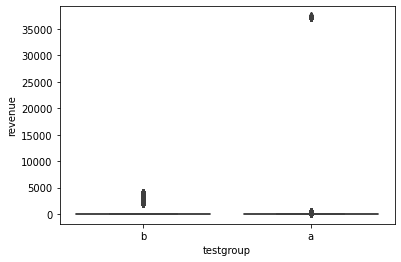

In [50]:
#видно уже тут, что распределение данных вряд ли нормальное и есть большой выброс в контрольной группе.
sns.boxplot(x='testgroup', y='revenue', data=df_AB)

Такой сильный выброс в контрольной группе может сильно помешать AB тесту, которые проверяет изменения ARPU и/или ARPPU в наших версиях. Давайте посмотрим подробнее:

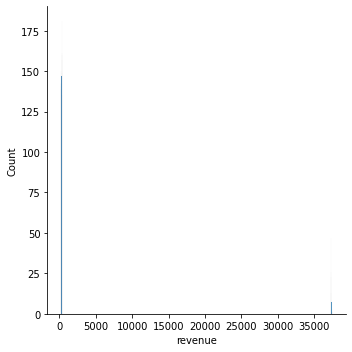

In [22]:
#График платящих пользователей в контрольной группе. 
sns.displot(control[control.revenue > 0], x="revenue")

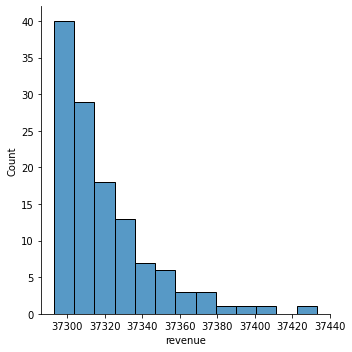

In [42]:
#График "китов" (пользователей, которые потратили более 35000) в контрольной группе. 
sns.displot(control[control.revenue > 35000], x="revenue")

In [51]:
control.query('revenue > 35000').agg({'user_id': 'count'})

user_id    123
dtype: int64

Мы видим, что в контрольной группе 123 потратили в игре больше 35000, а остальная часть платящей аудитории только чуть-чуть больше нуля. В группе экспериментальной такой разницы пользователей мы не наблюдаем. 

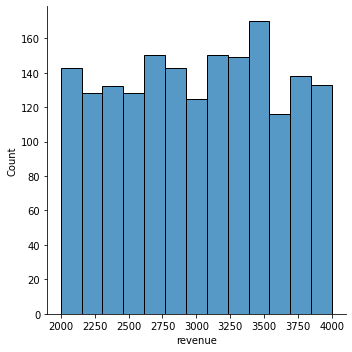

In [17]:
#График платящих пользователей в тестовой группе. 
sns.displot(test[test.revenue > 0], x="revenue")

К сожалению, наши опасения оправдались. По итогу, в контрольной группе у нас какие-то очень разные юзеры, одни тратят  чуть больше 0, другие больше 35000. Есть ощущение, что в контрольную группы к нам из платящих к нам попали одни "киты" и "карпы", а в тестовую только "дельфины". Такой сильный разброс в группе мешает репрезентативности наших подвыборок. Это критично для проведения A/B теста, ведь с таким разными пользователями в группах мы не можем уверенно делать выводы насчёт влияния набора предложений на ARPU и ARPPU.  

В этом случае можно проверить конверсию в покупку в тествой и контрольной группе: 

- $H_0$: расхождения статистически не значимы
- $H_1$: расхождения статистически значимы

Есть две категориальные переменные → нужен хи-квадрат

In [34]:
df_AB 

,user_id,revenue,testgroup,CR
0,1,0,b,not_converted
1,2,0,a,not_converted
2,3,0,a,not_converted
3,4,0,b,not_converted
4,5,0,b,not_converted
...,...,...,...,...
404765,404766,0,a,not_converted
404766,404767,0,b,not_converted
404767,404768,231,a,converted
404768,404769,0,a,not_converted


In [52]:
df_AB['CR'] = df_AB.revenue.apply(lambda x: 'converted' if x > 0 else 'not_converted')

In [36]:
pd.crosstab(df_AB.CR, df_AB.testgroup)

testgroup,a,b
CR,,
converted,1928,1805
not_converted,200175,200862


In [37]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_AB.CR, df_AB.testgroup))

In [38]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [39]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Нулевая гипотеза отклонена, поскольку p-value < 0. 05, то есть различия статистически значимы. Проще говоря, конверсия в покупку в контрольной группе действительно больше. 

# Выводы:

Если кратко: конверсия в контрольной группе больше, поэтому есть смысл оставить набор акционных предложений из этой группы. 


Конечно, очень, жаль, что не получилось сравнить ARPU и ARPPU в наших группах. Чтобы проверить эти гипотезы, мы бы могли использовать Т-тест Стьюдента, если бы у нас было:

1. Средние значения двух сравниваемых групп подчинялись нормальному распределению. Это можно было бы проверить бутстрэпом средних наших выборок. Такой приём допустим если нет больших выбросов (которые значимо смещают среднюю от нормальности) даже когда само распределение наблюдений в каждой группе ненормально.


2. Если размеры выборки в двух сравниваемых группах равны, то t-критерий Стьюдента требует равенство дисперсий (можно проверить критерия Левена и критерия Фишера). Если бы это условие не выполнялось, то можно использовать Т-тест Критерий Уэлча, который нечувствителен к равенству дисперсий независимо от того, одинаковы ли размеры выборки.


Я думаю, имеет смысл провести новый АБ тест. Всё-таки мы нашли различия в ARPPU в тестовой группе больше чем в контрольной (3004 против 2664), просто сейчас это может быть обусловлено как реальными большими тратами пользователей, так и тем, что у нас случайно в контрольную и экспериментальную группы попали пользователи с совсем разной покупательской способность. К тому же, мы "нащупали" какое-то различие в коверсии между группами, но для лучшего понимания природы этого различия лучше набрать репрезентативные выборки и проанализировать результаты (например, proportion z-test или bootstrap, они позволят вывести доверительный интервал). Нам нужно лучше следить за нашим дизайном выборок и подвыборок, а также за тем, как работает наша сплит система трафика. При достаточных бюджетах, можно предварительно запустить АА тест. Тогда, мы найдем точный путь повышения наших доходов.  

--------------------------------------

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Конечно, набор метрик для оценки  результаты последнего прошедшего события очень сильно зависит от модели монетизации игры. Где-то нам бы важнее было длинна сессии и количество просмотренных рекламных роликов, а где-то мы бы больше следили за влиянием события на ARPU/ARPPU. Предположим, то у нас **free-to-play** игра со **внутриигровыми покупками** и **встроенной рекламой**, так как сейчас это наиболее распространённая модель монетизации в мобильных играх. В данном случае, нам будет особенно важно проследить повлияло ли наше последнее событие и на удержание, и на метрики монетизации. 


Первое что нужно будет посмотреть, это собственно **конверсию** в начало прохождения тематического события. То есть ответить на вопрос: Сколько наших уникальных юзеров вообще решили пройти дополнительные уровни?  Также, можно построить **воронку**, которая описывает конверсию в дальнейшие уровни. Это поможет увидеть на каком уровне нашего события отваливаются пользователи и достаточно ли сбалансированы наши доп. уровни, чтобы пользователям было интересно, но и не слишком уж сложно. Конечно, нам также важно посмотреть как в целом доп. уровни влияют на базовые метрики нашего приложения. 


В зависимости от длинны события и количество уровней в нём, можно посмотреть  **Retention** 1 дня и/или Retention 3 дня и/или  Retention 7 дня (начиная с запуска тематического события, можно смотреть этот Retention по когортам, если дней много). Важно также проверить, а увеличивает ли событие наши **DAU** и **MAU** по сравнению с днями и месяцами, когда тематических событий нет. Можно также сравнить среднюю длину сессии за неделю с неделей без события. Стал ли наш пользователь проводить больше времени в игре? Ну и конечно проверить, а помогает ли наше событие увеличить нашу прибыль? Как раздача дополнительных монет и бонусов влияет на **ARPU** и **ARPPU**. Наш игрок теперь не хочет покупать ничего из магазина или наоборот теперь с новыми предметами больше замотивирован улучшить свой уровень?


Если мы усложнили механику событий, я бы оставила все предыдущее метрики, но уже гораздо бы внимательней смотрела бы, на воронку конверсии в следующие уровни и **winrate** уровней. Возможно, также дополнительно нужно было бы смотреть на **churn-rate** после события по всей игре в целом. Вдруг, наше тематическое событие не принесло пользователю приятное чувство победы, а раздражающее чувство поражения и теперь он или она совсем разочаровались в нашей игре :) 
Небольшое дополнение, все вышестоящие метрики можно смотреть в разрезе сегментаций, которые уже у нас есть в продукте. Например, посмотрела бы на метрики в разрезе  бесплатных игроков,  «карпов»,  «дельфинов» и  «китов».